1) Import Libraries

In [1]:
#Import Libraries

import yfinance as yf
import pandas as pd
import numpy as np
import backtesting
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply,crossover
import matplotlib.pyplot as plt
import get_variable_name
backtesting.set_bokeh_output(notebook=False)

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# backtesting.set_bokeh_output(notebook=False)

2a)Load Data

In [3]:
url_snp500 = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
url_amex = 'https://raw.githubusercontent.com/GunnarPDX/csv_tickers/master/amex.csv'
url_nasdaq = 'https://raw.githubusercontent.com/GunnarPDX/csv_tickers/master/nasdaq.csv'
url_nyse = 'https://raw.githubusercontent.com/GunnarPDX/csv_tickers/master/nyse.csv'
#for optimising use
tickers_snp500 = pd.read_csv(url_snp500)
tickers_snp500 = tickers_snp500[(tickers_snp500.Symbol != 'BF.B')]
tickers_snp500 = tickers_snp500[(tickers_snp500.Symbol != 'BRK.B')]
#for backtesting use
tickers_amex = pd.read_csv(url_amex)
tickers_amex = tickers_amex[tickers_amex.Symbol != "BWL/A"]
tickers_nasdaq = pd.read_csv(url_nasdaq)
tickers_nasdaq = tickers_nasdaq.replace("/","")
tickers_nyse = pd.read_csv(url_nyse)
tickers_nyse.Symbol = tickers_nyse.Symbol.replace("/","")


2b) Signal Functions -Functions for Indicators

In [4]:
#Simple Moving Average
def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()
#Average True Range Indicator
def ATR(high,low,close, n):
    high_low = pd.Series(high) - pd.Series(low)
    high_close = abs(pd.Series(high) - pd.Series(close))
    low_close = abs(pd.Series(low) - pd.Series(close))
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(n).sum()/n
    return atr

#Volatility of Volatility
def VOV(high,low,close, n1,n2,n3):
    high_low = pd.Series(high) - pd.Series(low)
    high_close = abs(pd.Series(high) - pd.Series(close))
    low_close = abs(pd.Series(low) - pd.Series(close))
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr1 = true_range.rolling(n1).sum()/n1
    atr2 = true_range.rolling(n2).sum()/n2
    atr = atr2-atr1
    vov = atr.rolling(n3).std()/n3
    return vov

3) Plot ATR

In [5]:
# a supplementary plot function for investigative work
def plot_atr(price_data,n1=10,n2=20,n3=10,n4=20) : 
    high_low = pd.Series(price_data["High"]) - pd.Series(price_data["Low"])
    high_close = abs(pd.Series(price_data["High"]) - pd.Series(price_data["Close"]))
    low_close = abs(pd.Series(price_data["Low"]) - pd.Series(price_data["Close"]))
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    price_data["atr1"] = true_range.rolling(n1).sum()/n1
    price_data["atr1"]= price_data["atr1"].replace(np.nan, 0)
    price_data["atr2"] = true_range.rolling(n2).sum()/n2
    price_data["atr2"]= price_data["atr2"].replace(np.nan, 0)
    price_data["atr_dif"]= price_data["atr2"] - price_data["atr1"]
    price_data["vov1"] = price_data["atr_dif"].rolling(n3).std()
    price_data["vov2"] = price_data["atr_dif"].rolling(n4).std()
    price_data["vov_dif"]=  price_data["vov2"] -  price_data["vov1"]  
    fig, axs = plt.subplots(3,1,figsize=(15,15))
    axs[0].set_ylabel('Price')
    axs[0].plot(price_data['Close'],color="red")
    axs[0].set_title('Price and ATR')
    axs[1].set_ylabel('ATR')
    #axs[1].plot(price_data["atr1"],color="red")
    #axs[1].plot(price_data["atr2"],color="green")
    ax2a=axs[1].twinx()
    ax2a.plot(price_data["atr_dif"],color="blue")
    axs[1].set_title('ATR Indicator')
    axs[2].plot(price_data["vov_dif"],color="green")
    axs[2].set_ylabel('ATR^2')    
    axs[2].set_title('Volatility of ATR')
    plt.show()

[*********************100%***********************]  1 of 1 completed


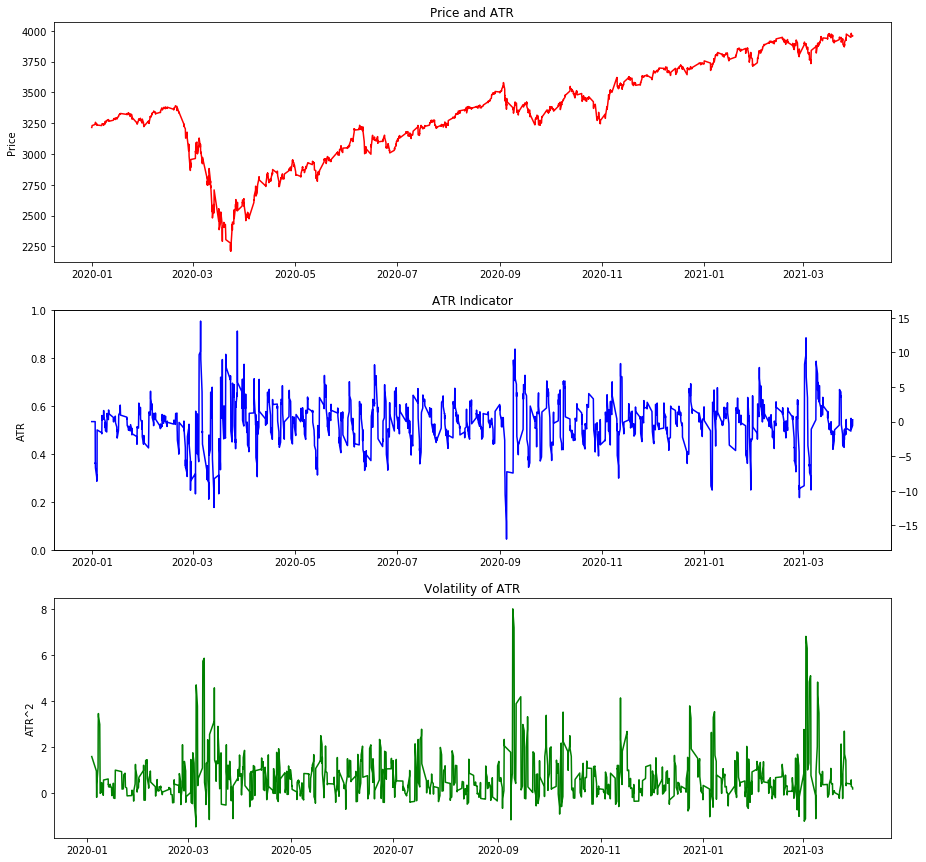

In [6]:
# try out on the plot of of ATR vs VOV
snp500 = yf.download(tickers="^GSPC",interval="60m",auto_adjust=True,start="2020-01-01", end="2021-03-31")
plot_atr(snp500,n1=10,n2=20)

4) Strategy Functions. Creating Classes representing each strategy

In [7]:
class SMASystemwithoutVolatilityFilter(Strategy):
    stoploss = 98
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,10)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,20)
    def next(self):
        price = self.data.Close[-1]
        if (not self.position and
            self.ma10[-1] > self.ma20[-1]):
            self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

In [8]:
class SMASystemwithVolatilityFilter(Strategy):
    stoploss = 98
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,10)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,20)

    def next(self):
        price = self.data.Close[-1]
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.ma10[-1] > self.ma20[-1] and
            self.atr10[-1] >   self.atr20[-1]):
             self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

To include an optimisation to find the best ATR period for N1 and N2, backtested against the S&P 500 data over the same period. 

In [9]:
optimised_result =[]
for n2 in range(10,300,10):
    for n1 in range(10,300,10): 
        if n1==n2:
            break
        class tooptimiseSMASystemwithVolatilityFilter(Strategy):
            stoploss = 98
            def init(self):
                # Compute moving averages the strategy demands
                self.ma10 = self.I(SMA, self.data.Close, 10)
                self.ma20 = self.I(SMA, self.data.Close, 20)
                self.ma50 = self.I(SMA, self.data.Close, 50)
                self.ma100 = self.I(SMA, self.data.Close, 100)
                self.atrn1 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,n1)
                self.atrn2 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,n2)
            def next(self):
                price = self.data.Close[-1]
                # If we don't already have a position, and
                # if all conditions are satisfied, enter long.
                if (not self.position and
                    self.ma10[-1] > self.ma20[-1] and
                    self.atrn1[-1] >   self.atrn2[-1]):
                     self.buy(size=1)
                elif self.ma10[-1] < self.ma20[-1]:
                    self.position.close()                 
        result=Backtest(snp500, tooptimiseSMASystemwithVolatilityFilter, cash=10000,commission=0.01, margin=1).run()
        optimised_result.append([n1,n2,result["Equity Final [$]"]])

The optimised N1 and N2 are then used as part of another strategy to identify if any improvement to trading result. 

In [10]:
n_op1,n_op2,maxequity = optimised_result[[row[2] for row in optimised_result].index(max([row[2] for row in optimised_result]))]
print(n_op1,n_op2,maxequity)

100 250 9278.106232910153


In [11]:
class SMASystemwithVolatilityFilter2(Strategy):
    stoploss = 98    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,n_op1)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,n_op2)

    def next(self):
        price = self.data.Close[-1]
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.ma10[-1] > self.ma20[-1] and
            self.atr10[-1] >   self.atr20[-1]):
             self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

In [12]:
class SMASystemwithReversedVolatilityFilter(Strategy):
    stoploss = 98
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,10)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,20)
    def next(self):
        price = self.data.Close[-1]
        if (not self.position and
            self.ma10[-1] > self.ma20[-1] and
            self.atr10[-1] <   self.atr20[-1]):
            self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

In [13]:
class SMASystemwithVovFilter(Strategy):
    stoploss = 98
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)        
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,10)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,20)
        self.vov10 = self.I(VOV, self.data.High, self.data.Low,self.data.Close,10,20,10)
        self.vov20 = self.I(VOV, self.data.High, self.data.Low,self.data.Close,10,20,20)
    def next(self):
        price = self.data.Close[-1]
        if (not self.position and
            self.ma10[-1] > self.ma20[-1] and
            self.vov10[-1] >   self.vov20[-1]):
            self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

Volatility of Volatility Filter did not perform as good as expected to the trading. Hence, also additional include the strategy using the reversed signal from Volatility of Volatility filter 

In [15]:
class SMASystemwithVovFilter2(Strategy):
    stoploss = 98
    def init(self):
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)        
        self.atr10 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,10)
        self.atr20 = self.I(ATR, self.data.High, self.data.Low,self.data.Close,20)
        self.vov10 = self.I(VOV, self.data.High, self.data.Low,self.data.Close,10,20,10)
        self.vov20 = self.I(VOV, self.data.High, self.data.Low,self.data.Close,10,20,20)
    def next(self):
        price = self.data.Close[-1]
        if (not self.position and
            self.ma10[-1] > self.ma20[-1] and
            #the only change to SMASystemwithVovFilter
            self.vov10[-1] <   self.vov20[-1]):
            self.buy(size=1)
        elif self.ma10[-1] < self.ma20[-1]:
            self.position.close()

In [16]:
class BuyandHold(Strategy):
    stoploss = 98
    def init(self):
        pass
    def next(self):
        if (not self.position):
            self.buy(size=1)

5) Summary functions to calculate the data of each strategy. "calculate_result" is to carry out the backtesting for all data, while "Result" class stores all the trading performance of all strategies.

In [17]:
#To extract the important parameters only
def calculate_result(price_data, strategy,cash=10000,commission=0.01,margin=1):
    result = Backtest(price_data, strategy, cash=cash,commission=commission, margin=margin).run()
    return {"Exposure Time [%]" : result["Exposure Time [%]"],
            "Equity Final [$]" :result["Equity Final [$]"],
            "Equity Peak [$]" :result["Equity Peak [$]"],
            "Return (Ann.) [%]" :result["Return (Ann.) [%]"],
            "Volatility (Ann.) [%]" :result["Volatility (Ann.) [%]"],
            "Sharpe Ratio" :result["Return (Ann.) [%]"]/result["Volatility (Ann.) [%]"],
            "Calmar Ratio" :result["Calmar Ratio"],
            "Max. Drawdown Duration" :result["Max. Drawdown Duration"],
            "Avg. Drawdown [%]" :result["Avg. Drawdown [%]"],
            "Max. Drawdown Duration" :result["Max. Drawdown Duration"],
            "Avg. Drawdown Duration" :result["Avg. Drawdown Duration"],
            "# Trades" :result["# Trades"],
            "Win Rate [%]" :result["Win Rate [%]"],
            "Best Trade [%]" :result["Best Trade [%]"],
            "Worst Trade [%]" :result["Worst Trade [%]"],
            "Max. Trade Duration" :result["Max. Trade Duration"],
            "Avg. Trade Duration" :result["Avg. Trade Duration"],
            "Profit Factor" :result["Profit Factor"],
            "Expectancy [%]" :result["Expectancy [%]"]}

In [18]:
class Result:
    def __init__(self, price_data):
        # Compute moving averages the strategy demands
        self.strategy1 = calculate_result(price_data,SMASystemwithoutVolatilityFilter)
        self.strategy2 = calculate_result(price_data,SMASystemwithVolatilityFilter)
        self.strategy2a = calculate_result(price_data,SMASystemwithVolatilityFilter2)        
        self.strategy3 = calculate_result(price_data,SMASystemwithReversedVolatilityFilter)        
        self.strategy4 = calculate_result(price_data,SMASystemwithVovFilter)
        self.strategy4a = calculate_result(price_data,SMASystemwithVovFilter2)
        self.strategy5 = calculate_result(price_data,BuyandHold)

        self.data = {"S1 Exposure Time [%]" : [self.strategy1["Exposure Time [%]"]],
                     "S2 Exposure Time [%]" : [self.strategy2["Exposure Time [%]"]],
                     "S2a Exposure Time [%]" : [self.strategy2["Exposure Time [%]"]],
                     "S3 Exposure Time [%]" : [self.strategy3["Exposure Time [%]"]],
                     "S4 Exposure Time [%]" : [self.strategy4["Exposure Time [%]"]],
                     "S4a Exposure Time [%]" : [self.strategy4a["Exposure Time [%]"]],
                     "S5 Exposure Time [%]" : [self.strategy5["Exposure Time [%]"]],
                     "S1 Return (Ann.) [%]" : [self.strategy1["Return (Ann.) [%]"]],
                     "S2 Return (Ann.) [%]" : [self.strategy2["Return (Ann.) [%]"]],
                     "S2a Return (Ann.) [%]" : [self.strategy2["Return (Ann.) [%]"]],
                     "S3 Return (Ann.) [%]" : [self.strategy3["Return (Ann.) [%]"]],
                     "S4 Return (Ann.) [%]" : [self.strategy4["Return (Ann.) [%]"]],
                     "S4a Return (Ann.) [%]" : [self.strategy4a["Return (Ann.) [%]"]],
                     "S5 Return (Ann.) [%]" : [self.strategy5["Return (Ann.) [%]"]],
                     "S1 Volatility (Ann.) [%]" : [self.strategy1["Volatility (Ann.) [%]"]],
                     "S2 Volatility (Ann.) [%]" : [self.strategy2["Volatility (Ann.) [%]"]],
                     "S2a Volatility (Ann.) [%]" : [self.strategy2["Volatility (Ann.) [%]"]],
                     "S3 Volatility (Ann.) [%]" : [self.strategy3["Volatility (Ann.) [%]"]],
                     "S4 Volatility (Ann.) [%]" : [self.strategy4["Volatility (Ann.) [%]"]],
                     "S4a Volatility (Ann.) [%]" : [self.strategy4a["Volatility (Ann.) [%]"]],
                     "S5 Volatility (Ann.) [%]" : [self.strategy5["Volatility (Ann.) [%]"]],
                     "S1 Sharpe Ratio" : [self.strategy1["Sharpe Ratio"]],
                     "S2 Sharpe Ratio" : [self.strategy2["Sharpe Ratio"]],
                     "S2a Sharpe Ratio" : [self.strategy2a["Sharpe Ratio"]],
                     "S3 Sharpe Ratio" : [self.strategy3["Sharpe Ratio"]],
                     "S4 Sharpe Ratio" : [self.strategy4["Sharpe Ratio"]],
                     "S4a Sharpe Ratio" : [self.strategy4a["Sharpe Ratio"]],
                     "S5 Sharpe Ratio" : [self.strategy5["Sharpe Ratio"]],
                     "S1 Calmar Ratio" : [self.strategy1["Calmar Ratio"]],
                     "S2 Calmar Ratio" : [self.strategy2["Calmar Ratio"]],
                     "S2a Calmar Ratio" : [self.strategy2a["Calmar Ratio"]],
                     "S3 Calmar Ratio" : [self.strategy3["Calmar Ratio"]],
                     "S4 Calmar Ratio" : [self.strategy4["Calmar Ratio"]],
                     "S4a Calmar Ratio" : [self.strategy4a["Calmar Ratio"]],
                     "S5 Calmar Ratio" : [self.strategy5["Calmar Ratio"]],
                     "S1 # Trades" : [self.strategy1["# Trades"]],
                     "S2 # Trades" : [self.strategy2["# Trades"]],
                     "S2a # Trades" : [self.strategy2a["# Trades"]],
                     "S3 # Trades" : [self.strategy3["# Trades"]],
                     "S4 # Trades" : [self.strategy4["# Trades"]],
                     "S4a # Trades" : [self.strategy4a["# Trades"]],
                     "S5 # Trades" : [self.strategy5["# Trades"]],
                     "S1 Win Rate [%]" : [self.strategy1["Win Rate [%]"]],
                     "S2 Win Rate [%]" : [self.strategy2["Win Rate [%]"]],
                     "S2a Win Rate [%]" : [self.strategy2a["Win Rate [%]"]],
                     "S3 Win Rate [%]" : [self.strategy3["Win Rate [%]"]],
                     "S4 Win Rate [%]" : [self.strategy4["Win Rate [%]"]],
                     "S4a Win Rate [%]" : [self.strategy4a["Win Rate [%]"]],
                     "S5 Win Rate [%]" : [self.strategy5["Win Rate [%]"]],
                     "S1 Average Drawdown [%]" : [self.strategy1["Avg. Drawdown [%]"]],
                     "S2 Average Drawdown [%]" : [self.strategy2["Avg. Drawdown [%]"]],
                     "S2a Average Drawdown [%]" : [self.strategy2a["Avg. Drawdown [%]"]],
                     "S3 Average Drawdown [%]" : [self.strategy3["Avg. Drawdown [%]"]],
                     "S4 Average Drawdown [%]" : [self.strategy4["Avg. Drawdown [%]"]],
                     "S4a Average Drawdown [%]" : [self.strategy4a["Avg. Drawdown [%]"]],
                     "S5 Average Drawdown [%]" : [self.strategy5["Avg. Drawdown [%]"]]}                    

6) Carry out backtesting for all available tickers in AMEX exchange, NASDAQ exchange and NYSE Exchange

In [19]:
df_amex = pd.DataFrame()
for ticker in tickers_amex.Symbol :
    try:
        ticker = ticker.replace("/","")
        row = yf.download(tickers=ticker,interval="60m",auto_adjust=True,start="2020-01-01", end="2021-03-31")  
        result_row = Result(row)
        result_row_df = pd.DataFrame(result_row.data, index=[ticker])
        df_amex= pd.concat([df_amex,result_row_df])
    except:
        pass
df_amex = df_amex
df_amex.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GLU^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GLU^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,S1 Exposure Time [%],S2 Exposure Time [%],S2a Exposure Time [%],S3 Exposure Time [%],S4 Exposure Time [%],S4a Exposure Time [%],S5 Exposure Time [%],S1 Return (Ann.) [%],S2 Return (Ann.) [%],S2a Return (Ann.) [%],...,S4 Win Rate [%],S4a Win Rate [%],S5 Win Rate [%],S1 Average Drawdown [%],S2 Average Drawdown [%],S2a Average Drawdown [%],S3 Average Drawdown [%],S4 Average Drawdown [%],S4a Average Drawdown [%],S5 Average Drawdown [%]
AAMC,48.278689,42.131148,42.131148,38.606557,49.590164,28.196721,99.836066,-0.051479,-0.060622,-0.060622,...,29.032258,28.571429,100.0,-0.045389,-0.046041,-0.046264,-0.060178,-0.038469,-0.040355,-0.027584
AAU,47.392498,38.426349,38.426349,39.066789,46.294602,23.970723,99.908509,-0.002993,-0.003190,-0.003190,...,37.500000,34.210526,0.0,-0.002638,-0.003499,-0.001728,-0.001731,-0.001783,-0.003203,-0.001210
ACU,51.234892,43.983184,43.983184,42.669469,51.182344,33.420914,99.894903,-0.035829,-0.064532,-0.064532,...,41.509434,35.135135,100.0,-0.060242,-0.044224,-0.057418,-0.075291,-0.049215,-0.025287,-0.017785
ACY,45.177384,39.412417,39.412417,32.095344,44.567627,29.600887,99.889135,-0.014417,-0.027544,-0.027544,...,22.916667,17.142857,100.0,-0.059630,-0.071253,-0.069443,-0.012185,-0.109560,-0.040130,-0.061943
AEF,56.167608,49.623352,49.623352,51.506591,57.109228,29.990584,99.905838,-0.020024,-0.015361,-0.015361,...,27.777778,17.647059,100.0,-0.025837,-0.006929,-0.010772,-0.024356,-0.009058,-0.008502,-0.001996


In [20]:
df_nasdaq = pd.DataFrame()
for ticker in tickers_nasdaq.Symbol :
    try: 
        ticker = ticker.replace("/","")
        row = yf.download(tickers=ticker,interval="60m",auto_adjust=True,start="2020-01-01", end="2021-03-31")
        result_row = Result(row)
        result_row_df = pd.DataFrame(result_row.data, index=[ticker])
        df_nasdaq= pd.concat([df_nasdaq,result_row_df])
    except:
        pass
df_nasdaq = df_nasdaq
df_nasdaq.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FCACW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GMBLW: No data found for this date range, symbol may be delisted
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MAACW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MACUW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NEBCW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PPGHW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,S1 Exposure Time [%],S2 Exposure Time [%],S2a Exposure Time [%],S3 Exposure Time [%],S4 Exposure Time [%],S4a Exposure Time [%],S5 Exposure Time [%],S1 Return (Ann.) [%],S2 Return (Ann.) [%],S2a Return (Ann.) [%],...,S4 Win Rate [%],S4a Win Rate [%],S5 Win Rate [%],S1 Average Drawdown [%],S2 Average Drawdown [%],S2a Average Drawdown [%],S3 Average Drawdown [%],S4 Average Drawdown [%],S4a Average Drawdown [%],S5 Average Drawdown [%]
AACG,46.081993,39.491437,39.491437,34.561495,45.926310,24.338350,99.896212,0.025161,0.026243,0.026243,...,32.142857,25.641026,100.0,-0.023303,-0.026647,-0.015121,-0.019099,-0.016951,-0.027085,-0.012046
AACQ,50.880829,44.455959,44.455959,40.000000,49.119171,28.601036,99.792746,-0.065039,-0.064645,-0.064645,...,15.384615,10.526316,0.0,-0.036654,-0.036432,-0.007135,-0.006855,-0.040303,-0.037553,-0.004891
AACQU,52.828467,45.711679,45.711679,46.532847,53.284672,28.102190,99.817518,-0.012480,-0.024906,-0.024906,...,24.137931,33.333333,100.0,-0.009379,-0.017195,-0.016363,-0.008240,-0.017103,-0.004407,-0.003957
AACQW,46.861925,40.585774,40.585774,40.167364,46.652720,29.916318,99.790795,0.004529,-0.000585,-0.000585,...,34.782609,42.857143,0.0,-0.002049,-0.002292,-0.001796,-0.001419,-0.002199,-0.001794,-0.004420
AAL,48.421053,42.745995,42.745995,39.908467,49.153318,23.249428,99.908467,0.015387,-0.008021,-0.008021,...,33.333333,33.333333,0.0,-0.058679,-0.085657,-0.059371,-0.017371,-0.052936,-0.032052,-0.045173


In [21]:
df_nyse = pd.DataFrame()
for ticker in tickers_nyse.Symbol:
    try: 
        ticker = ticker.replace("/","")
        row = yf.download(tickers=ticker,interval="60m",auto_adjust=True,start="2020-01-01", end="2021-03-31")
        result_row = Result(row)
        result_row_df = pd.DataFrame(result_row.data, index=[ticker])
        df_nyse= pd.concat([df_nyse,result_row_df])
    except:
        pass
df_nyse = df_nyse
df_nyse.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAIC^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAIC^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AHT^I: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AIG^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- APTV^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BAC^A: No data found, symbol may be delisted
[*********************100%**********

- BHR^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHR^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BIOB: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BIP^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 comp

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- C^J: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- C^K: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- C^N: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIM^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIM^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIO^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIT^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CRDA: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DHR^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DHR^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EFC^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^G: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^H: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^I: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^J: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^K: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC^L: No data found, 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GL^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GLOG^A: No data

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HEIA: No dat

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JPM^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JPM^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JPM^G: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JPM^H: No data found, symbol may be delisted
[*********************100%****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MH^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MH^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MH^D: No data found, symbol may be delisted
[*********************100%*****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NMK^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NMK^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OFG^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OFG^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OFG^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**************

C:\Users\gerardsho\AppData\Local\Continuum\anaconda3\lib\site-packages\backtesting\backtesting.py:1584: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PMT^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PMT^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PNC^P: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QTS^A: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QTS^B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- STT^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- STT^G: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UMH^C: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UMH^D: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WBS^F: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,S1 Exposure Time [%],S2 Exposure Time [%],S2a Exposure Time [%],S3 Exposure Time [%],S4 Exposure Time [%],S4a Exposure Time [%],S5 Exposure Time [%],S1 Return (Ann.) [%],S2 Return (Ann.) [%],S2a Return (Ann.) [%],...,S4 Win Rate [%],S4a Win Rate [%],S5 Win Rate [%],S1 Average Drawdown [%],S2 Average Drawdown [%],S2a Average Drawdown [%],S3 Average Drawdown [%],S4 Average Drawdown [%],S4a Average Drawdown [%],S5 Average Drawdown [%]
A,58.287293,49.355433,49.355433,53.268877,59.346225,25.230203,99.907919,-0.496787,-0.294069,-0.294069,...,22.058824,25.806452,100.0,-0.631495,-0.382147,-0.154028,-0.561840,-0.662596,-0.177363,-0.022968
AA,51.449609,46.019328,46.019328,45.927289,51.633686,20.846756,99.907961,0.033277,0.001687,0.001687,...,35.087719,34.615385,100.0,-0.018076,-0.017157,-0.010433,-0.015636,-0.025340,-0.057743,-0.020123
AAIC,49.379310,41.379310,41.379310,43.310345,52.965517,21.379310,99.724138,-0.010127,-0.001990,-0.001990,...,33.333333,8.333333,100.0,-0.001590,-0.001198,-0.002578,-0.001524,-0.002008,-0.004468,-0.001102
AAN,50.260870,44.000000,44.000000,44.173913,54.608696,22.956522,99.652174,0.066807,0.006435,0.006435,...,53.846154,25.000000,0.0,-0.011686,-0.012237,-0.037307,-0.010146,-0.009988,-0.009021,-0.500678
AAP,52.231937,45.467096,45.467096,45.006903,52.508053,22.365393,99.907961,-0.176862,-0.337858,-0.337858,...,33.928571,28.571429,100.0,-0.122524,-0.271574,-0.116921,-0.133863,-0.150716,-0.522477,-0.088345


7) Tabulation and Evaluation of Results

In [25]:
result_table = {}
for df_string in ["df_amex","df_nasdaq","df_nyse"]:   
    df = eval(df_string)
    df["isVolatilityFilterEffective?"] = (df["S2 Calmar Ratio"] >= df["S1 Calmar Ratio"])&(df["S2 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityFilterHigherinReturn?"] = (df["S2 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityFilterHigherinCalmarRatio?"] = (df["S2 Calmar Ratio"] >= df["S1 Calmar Ratio"])   
    df["istradereducedusingVolatilityFilter?"] = (df["S2 # Trades"] < df["S1 # Trades"])
    df["isdrawdownlowerusingVolatilityFilter?"] = (df["S2 Average Drawdown [%]"] < df["S1 Average Drawdown [%]"])
    #
    df["isVolatilityFilter2Effective?"] = (df["S2a Calmar Ratio"] >= df["S1 Calmar Ratio"])&(df["S2a Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityFilter2HigherinReturn?"] = (df["S2a Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityFilter2HigherinCalmarRatio?"] = (df["S2a Calmar Ratio"] >= df["S1 Calmar Ratio"])   
    df["istradereducedusingVolatilityFilter2?"] = (df["S2a # Trades"] < df["S1 # Trades"])
    df["isdrawdownlowerusingVolatilityFilter2?"] = (df["S2a Average Drawdown [%]"] < df["S1 Average Drawdown [%]"]) 
   #
    df["isRevVolatilityBetter?"] = (df["S3 Calmar Ratio"] >= df["S1 Calmar Ratio"])&(df["S3 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isRevVolatilityFilterHigherinReturn?"] = (df["S3 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isRevVolatilityFilterHigherinCalmarRatio?"] = (df["S3 Calmar Ratio"] >= df["S1 Calmar Ratio"])
    df["istradereducedusingRevVolatilityFilter?"] = (df["S3 # Trades"] < df["S1 # Trades"])
    df["isdrawdownlowerusingRevVolatilityFilter?"] = (df["S3 Average Drawdown [%]"] < df["S1 Average Drawdown [%]"])      
    #    
    df["isVolatilityofVolatilityEffective?"] = (df["S4 Calmar Ratio"] >= df["S1 Calmar Ratio"])&(df["S4 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityofVolatilityHigherinReturn?"] = (df["S4 Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityofVolatilityFilterHigherinCalmarRatio?"] = (df["S4 Calmar Ratio"] >= df["S1 Calmar Ratio"])
    df["istradereducedusingVolatilityofVolatilityFilter?"] = (df["S4 # Trades"] < df["S1 # Trades"])
    df["isdrawdownlowerusingVolatilityofVolatilityFilter?"] = (df["S4 Average Drawdown [%]"] < df["S1 Average Drawdown [%]"])  
    #
    df["isVolatilityofVolatility2Effective?"] = (df["S4a Calmar Ratio"] >= df["S1 Calmar Ratio"])&(df["S4a Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityofVolatility2HigherinReturn?"] = (df["S4a Return (Ann.) [%]"] > df["S1 Return (Ann.) [%]"])
    df["isVolatilityofVolatilityFilter2HigherinCalmarRatio?"] = (df["S4a Calmar Ratio"] >= df["S1 Calmar Ratio"])
    df["istradereducedusingVolatilityofVolatilityFilter2?"] = (df["S4a # Trades"] < df["S1 # Trades"])
    df["isdrawdownlowerusingVolatilityofVolatilityFilter2?"] = (df["S4a Average Drawdown [%]"] < df["S1 Average Drawdown [%]"])  
    #    
    
    conclusion_1a = df["isVolatilityFilterEffective?"].sum()/df["isVolatilityFilterEffective?"].count()
    conclusion_1b = df["isVolatilityFilterHigherinReturn?"].sum()/df["isVolatilityFilterHigherinReturn?"].count()
    conclusion_1c = df["isVolatilityFilterHigherinCalmarRatio?"].sum()/df["isVolatilityFilterHigherinCalmarRatio?"].count()    
    conclusion_1d = df["istradereducedusingVolatilityFilter?"].sum()/df["istradereducedusingVolatilityFilter?"].count()
    conclusion_1e = df["isdrawdownlowerusingVolatilityFilter?"].sum()/df["isdrawdownlowerusingVolatilityFilter?"].count()
    #
    conclusion_2a = df["isRevVolatilityBetter?"].sum()/df["isRevVolatilityBetter?"].count()
    conclusion_2b = df["isRevVolatilityFilterHigherinReturn?"].sum()/df["isRevVolatilityFilterHigherinReturn?"].count()
    conclusion_2c = df["isRevVolatilityFilterHigherinCalmarRatio?"].sum()/df["isRevVolatilityFilterHigherinCalmarRatio?"].count()
    conclusion_2d = df["istradereducedusingRevVolatilityFilter?"].sum()/df["istradereducedusingRevVolatilityFilter?"].count()
    conclusion_2e = df["isdrawdownlowerusingRevVolatilityFilter?"].sum()/df["isdrawdownlowerusingRevVolatilityFilter?"].count()
    #
    conclusion_3a = df["isVolatilityofVolatilityEffective?"].sum()/df["isVolatilityofVolatilityEffective?"].count()
    conclusion_3b = df["isVolatilityofVolatilityHigherinReturn?"].sum()/df["isVolatilityofVolatilityHigherinReturn?"].count()
    conclusion_3c = df["isVolatilityofVolatilityFilterHigherinCalmarRatio?"].sum()/df["isVolatilityofVolatilityFilterHigherinCalmarRatio?"].count()
    conclusion_3d = df["istradereducedusingVolatilityofVolatilityFilter?"].sum()/df["istradereducedusingVolatilityofVolatilityFilter?"].count()
    conclusion_3e = df["isdrawdownlowerusingVolatilityofVolatilityFilter?"].sum()/df["isdrawdownlowerusingVolatilityofVolatilityFilter?"].count()   
#added after draft submission 
    conclusion_4a = df["isVolatilityofVolatility2Effective?"].sum()/df["isVolatilityofVolatility2Effective?"].count()
    conclusion_4b = df["isVolatilityofVolatility2HigherinReturn?"].sum()/df["isVolatilityofVolatility2HigherinReturn?"].count()
    conclusion_4c = df["isVolatilityofVolatilityFilter2HigherinCalmarRatio?"].sum()/df["isVolatilityofVolatilityFilter2HigherinCalmarRatio?"].count()
    conclusion_4d = df["istradereducedusingVolatilityofVolatilityFilter2?"].sum()/df["istradereducedusingVolatilityofVolatilityFilter2?"].count()
    conclusion_4e = df["isdrawdownlowerusingVolatilityofVolatilityFilter2?"].sum()/df["isdrawdownlowerusingVolatilityofVolatilityFilter2?"].count()       

    conclusion_5a = df["isVolatilityFilter2Effective?"].sum()/df["isVolatilityFilter2Effective?"].count()
    conclusion_5b = df["isVolatilityFilter2HigherinReturn?"].sum()/df["isVolatilityFilter2HigherinReturn?"].count()
    conclusion_5c = df["isVolatilityFilter2HigherinCalmarRatio?"].sum()/df["isVolatilityFilter2HigherinCalmarRatio?"].count()    
    conclusion_5d = df["istradereducedusingVolatilityFilter2?"].sum()/df["istradereducedusingVolatilityFilter2?"].count()
    conclusion_5e = df["isdrawdownlowerusingVolatilityFilter2?"].sum()/df["isdrawdownlowerusingVolatilityFilter2?"].count()
    
    
    result_table[df_string]= [round(conclusion_1a,4)*100,round(conclusion_1b,4)*100,round(conclusion_1c,4)*100,round(conclusion_1e,4)*100,
                              round(conclusion_1d,4)*100,round(conclusion_2a,4)*100,round(conclusion_2b,4)*100,
                              round(conclusion_2c,4)*100,round(conclusion_2e,4)*100,round(conclusion_2d,4)*100,round(conclusion_3a,4)*100,
                              round(conclusion_3b,4)*100,round(conclusion_3c,4)*100,round(conclusion_3e,4)*100,round(conclusion_3d,4)*100,
                              round(conclusion_4a,4)*100,
                              round(conclusion_4b,4)*100,round(conclusion_4c,4)*100,round(conclusion_4e,4)*100,round(conclusion_4d,4)*100,
                              round(conclusion_5a,4)*100,
                              round(conclusion_5b,4)*100,round(conclusion_5c,4)*100,round(conclusion_5e,4)*100,round(conclusion_5d,4)*100                        
                             ]

8) Conclusion

In [26]:
conclusion = pd.DataFrame(result_table,index=["Does Volatility Filter result in higher return and Calmer ratio? (%)",
                                              "Does Volatility Filter result in higher return? (%)",
                                              "Does Volatility Filter result in higher Calmer ratio? (%)",
                                              "Does Volatility Filter result in lower drawdown? (%)",                                              
                                              "Does Volatility Filter result in trade reduction? (%)",
                                              "Does Reversed Volatility Filter result in higher return and Calmer ratio? (%)",
                                              "Does Reversed Volatility Filter result in higher return? (%)",
                                              "Does Reversed Volatility Filter result in higher Calmer ratio? (%)",
                                              "Does Reversed Volatility Filter result in lower drawdown? (%)",   
                                              "Does Reversed Volatility Filter result in trade reduction? (%)",
                                              "Does Volatility of Volatility Filter result in higher return and Calmer ratio? (%)",
                                              "Does Volatility of Volatility Filter result in higher return? (%)",
                                              "Does Volatility of Volatility Filter result in higher Calmer ratio? (%)",
                                              "Does Volatility of Volatility Filter result in lower drawdown? (%)",
                                              "Does Volatility of Volatility Filter result in trade reduction? (%)",
                                              # added after draft submission
                                              "Does the Volatility of Volatility Filter2 result in higher return and Calmer ratio? (%)",
                                              "Does Volatility of Volatility Filter2 result in higher return? (%)",
                                              "Does Volatility of Volatility Filter2 result in higher Calmer ratio? (%)",
                                              "Does Volatility of Volatility Filter2 result in lower drawdown? (%)",
                                              "Does Volatility of Volatility Filter2 result in trade reduction? (%)",
                                              "Does Volatility Filter2 result in higher return and Calmer ratio? (%)",
                                              "Does Volatility Filter2 result in higher return? (%)",
                                              "Does Volatility Filter2 result in higher Calmer ratio? (%)",
                                              "Does Volatility Filter2 result in lower drawdown? (%)",
                                              "Does Volatility Filter2 result in trade reduction? (%)",
                                 ])

In [27]:
conclusion.index.name = "Conclusion"
conclusion

,df_amex,df_nasdaq,df_nyse
Conclusion,,,
Does Volatility Filter result in higher return and Calmer ratio? (%),46.67,53.44,54.87
Does Volatility Filter result in higher return? (%),47.11,53.63,54.95
Does Volatility Filter result in higher Calmer ratio? (%),81.33,84.83,91.28
Does Volatility Filter result in lower drawdown? (%),49.78,44.63,43.53
Does Volatility Filter result in trade reduction? (%),99.56,97.74,98.86
Does Reversed Volatility Filter result in higher return and Calmer ratio? (%),62.22,60.28,59.33
Does Reversed Volatility Filter result in higher return? (%),62.22,60.57,59.50
Does Reversed Volatility Filter result in higher Calmer ratio? (%),84.89,86.00,90.90
Does Reversed Volatility Filter result in lower drawdown? (%),32.44,36.11,39.02


9) Conclusion

In [28]:
#Dont Overwrite First
print(len(df_amex))
print(len(df_nasdaq))
print(len(df_nyse))

225
3099
2373


In [32]:
result_table = {}
#for df_string in ["df_amex","df_nasdaq","df_nyse"]:
for df_string in ["df_amex","df_nasdaq","df_nyse"]:
    df = eval(df_string)
    print(df_string, df["S1 # Trades"].sum(),df["S2 # Trades"].sum(),df["S3 # Trades"].sum(),df["S4 # Trades"].sum())
    print(df_string, df["S2 # Trades"].sum()+df["S3 # Trades"].sum()+df["S4 # Trades"].sum())
    print(df_string, df["S2a # Trades"].sum()+df["S4a # Trades"].sum())

df_amex 11853 10282 10829 11859
df_amex 32970
df_amex 13213
df_nasdaq 148663 129631 136623 150283
df_nasdaq 416537
df_nasdaq 161989
df_nyse 125119 111072 116789 126720
df_nyse 354581
df_nyse 131154


In [30]:
#10 Sample Appendix
#Display Table of All Tickers and Their Returns
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

In [35]:
df_amex.iloc[:,7:21]

,S1 Return (Ann.) [%],S2 Return (Ann.) [%],S2a Return (Ann.) [%],S3 Return (Ann.) [%],S4 Return (Ann.) [%],S4a Return (Ann.) [%],S5 Return (Ann.) [%],S1 Volatility (Ann.) [%],S2 Volatility (Ann.) [%],S2a Volatility (Ann.) [%],S3 Volatility (Ann.) [%],S4 Volatility (Ann.) [%],S4a Volatility (Ann.) [%],S5 Volatility (Ann.) [%]
AAMC,-0.051479,-0.060622,-0.060622,-0.044202,-0.011719,0.009522,0.043146,0.141786,0.137666,0.137666,0.125937,0.148689,0.128717,0.177968
AAU,-0.002993,-0.003190,-0.003190,-0.004179,-0.001897,-0.004933,-0.000609,0.005390,0.005126,0.005126,0.004336,0.005339,0.003819,0.007428
ACU,-0.035829,-0.064532,-0.064532,-0.101712,-0.015650,0.014223,0.117445,0.084755,0.078410,0.078410,0.078918,0.084730,0.066834,0.123537
ACY,-0.014417,-0.027544,-0.027544,-0.023457,-0.035889,-0.066726,0.020055,0.114947,0.115089,0.115089,0.023595,0.115631,0.028697,0.122500
AEF,-0.020024,-0.015361,-0.015361,-0.018285,-0.020382,-0.016045,0.006969,0.012365,0.010836,0.010836,0.011768,0.012032,0.008597,0.018445
AGE,-0.004671,-0.002075,-0.002075,-0.000817,-0.005295,-0.003265,-0.002274,0.018617,0.018078,0.018078,0.017803,0.018703,0.016020,0.021214
AIM,-0.008393,-0.008433,-0.008433,-0.008121,-0.016800,0.004575,0.012601,0.030828,0.030144,0.030144,0.017496,0.030775,0.015665,0.048343
AINC,0.045038,0.025532,0.025532,-0.009618,0.043797,0.003583,-0.124815,0.071882,0.069248,0.069248,0.053748,0.071415,0.050949,0.108417
AIRI,-0.015472,-0.014118,-0.014118,-0.012027,-0.016849,-0.003491,-0.008106,0.007514,0.007255,0.007255,0.006351,0.007694,0.005645,0.011731
AMBO,-0.005758,-0.033676,-0.033676,-0.007338,-0.020719,-0.019281,0.001788,0.030124,0.028664,0.028664,0.027054,0.030373,0.019685,0.037478
